# Predicting Pitcher Salary Using Regression Model
---
*By Ihza Gonzales*

Using the historical pitcher stats and salary, a regression model will be created to predict the salary.

## Import Libraries
---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import AdaBoostRegressor, VotingRegressor

import pickle

## Import Dataset
---

In [2]:
df = pd.read_csv('../data/past_salaries_pitch.csv').drop(['Unnamed: 0'], axis = 1)
df.head()

,playerID,yearID,W,L,ERA,IP,H,ER,HR,BB,SO,WHIP,salary
0,aasedo01,1986,6,7,2.98,81.7,71,27,6,28,67,1.21,600000
1,ackerji01,1986,2,4,4.35,60.0,63,29,6,22,32,1.42,367500
2,ackerji01,1986,3,8,3.79,95.0,100,40,7,26,37,1.33,367500
3,aguilri01,1986,10,7,3.88,141.7,145,61,15,36,104,1.28,130000
4,alexado01,1986,5,4,4.46,111.0,120,55,18,20,65,1.26,700000


In [3]:
df.shape

(13125, 13)

## Create X and y variables for Salary
---

In [4]:
X = df.drop(columns = ['playerID', 'salary', 'yearID'])
y = df['salary']
X.head()

,W,L,ERA,IP,H,ER,HR,BB,SO,WHIP
0,6,7,2.98,81.7,71,27,6,28,67,1.21
1,2,4,4.35,60.0,63,29,6,22,32,1.42
2,3,8,3.79,95.0,100,40,7,26,37,1.33
3,10,7,3.88,141.7,145,61,15,36,104,1.28
4,5,4,4.46,111.0,120,55,18,20,65,1.26


## Train Test Split
---

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3, random_state=42)

## Preprocessing
---
### Standard Scaler

In [6]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### PCA

In [7]:
pca = PCA(random_state=42)
X_train_p = pca.fit_transform(X_train_sc)
X_test_p = pca.transform(X_test_sc)

## Functions Implemented
---

In [8]:
def fit_models(x, y, x_test, y_test, model):
    """
    Function fits specified model
    Returns metrics for Train and Test Set
    """
    model.fit(x, y)
    
    print()
    print(f'Train')
    reg_metrics(x, y, model)
    
    print()
    print(f'Test')
    reg_metrics(x_test, y_test, model)

In [9]:
def reg_metrics(x, y, model):
    """
    Function predicts using a specified model.
    Returns MSE, RMSE, and R2
    """
    
    y_pred = model.predict(x)
    resids = y - y_pred

    mse = metrics.mean_squared_error(y, y_pred)
    rmse = metrics.mean_squared_error(y, y_pred, squared = False)
    score = model.score(x, y)
    
    print(model)
    print("R2: ", score)
    print("MSE: ", mse)
    print("RMSE: ", rmse)

## Voting Model
---

In [10]:
l_alphas = np.logspace(-3, 1, 100)
e_alphas = np.linspace(0.01, 1, 100)
enet_ratio = 0.05
r_alphas = np.logspace(0, 5, 220)

In [11]:
vote = VotingRegressor([
    ('ad', AdaBoostRegressor(random_state=42)),
    ('rid', RidgeCV(r_alphas, scoring='r2', cv=5)),
    ('las', LassoCV(alphas=l_alphas, cv=5, max_iter=50_000, n_jobs=-1)),
    ('enet_model', ElasticNetCV(alphas=e_alphas, l1_ratio=enet_ratio, cv=5, max_iter=3000, n_jobs=-1))
])

In [12]:
fit_models(X_train_p, y_train, X_test_p, y_test, vote)


Train
VotingRegressor(estimators=[('ad', AdaBoostRegressor(random_state=42)),
                            ('rid',
                             RidgeCV(alphas=array([1.00000000e+00, 1.05397680e+00, 1.11086709e+00, 1.17082814e+00,
       1.23402569e+00, 1.30063444e+00, 1.37083853e+00, 1.44483200e+00,
       1.52281940e+00, 1.60501632e+00, 1.69164996e+00, 1.78295980e+00,
       1.87919826e+00, 1.98063137e+00, 2.08753951e+00, 2.20021820e+00,
       2.31897894e...
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
                                          cv=5, l1_ratio=0.05, max_iter=3000,
    

## Save Model to Pickle File
---

In [13]:
with open('../model/salary_model_p.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(vote, pickle_out)

## Use Forecasted Stats from Time Series to Predict Salary
---
*This will be used for app*

In [14]:
df = pd.read_csv('../data/player_forecasts_pitch.csv').drop(['Unnamed: 0'], axis = 1)
df.head()

,name,W,L,ERA,IP,H,ER,HR,BB,SO,WHIP
0,Fernando Abad,0.0,0.0,7.363,3.0,4.0,1.0,0.0,0.0,4.0,1.65
1,Cory Abbott,0.0,0.0,7.965,9.6,6.0,9.0,3.0,10.0,8.0,1.96
2,Domingo Acevedo,0.0,0.0,7.010,2.4,3.0,2.0,2.0,0.0,2.0,1.29
3,Austin Adams,0.0,0.0,3.443,11.1,14.0,0.0,0.0,14.0,15.0,1.16
4,Keegan Akin,0.0,2.0,6.046,20.6,30.0,16.0,6.0,7.0,22.0,1.57


In [15]:
X = df.drop(columns = ['name'])

In [16]:
X = ss.transform(X)
X = pca.transform(X)

preds = vote.predict(X)

pred_df = pd.DataFrame(preds, columns = ['salary'], index = df['name'])

### Save to CSV and Pickle Files

In [17]:
pred_df.to_csv('../data/pred_salary_pitch.csv')

In [18]:
with open('../pickles/pred_salary_pitch.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(pred_df, pickle_out)

## EDA of Results
---
Predict on Current player stats and compare predicted stats vs actual stats

In [19]:
df = pd.read_csv('../data/mlb_players_pitch.csv').drop(['Unnamed: 0'], axis = 1)
df.head()

,MLBID,FIRSTNAME,LASTNAME,Player,Team,Age,W,L,ERA,IP,H,ER,HR,BB,K,WHIP,salary
0,472551,Fernando,Abad,Fernando Abad,BAL,35,0,0,5.60,17.2,23,11,1,7,10,1.70,"$570,500"
1,676265,Cory,Abbott,Cory Abbott,CHC,26,0,0,6.75,17.1,20,13,7,11,12,1.79,"$570,500"
2,642758,Domingo,Acevedo,Domingo Acevedo,OAK,27,0,0,3.27,11.0,9,4,3,4,9,1.18,"$570,500"
3,613534,Austin,Adams,Austin Adams,SD,30,3,2,4.10,52.2,28,24,1,35,76,1.20,"$580,200"
4,669211,Keegan,Akin,Keegan Akin,BAL,26,2,10,6.63,95.0,110,70,17,40,82,1.58,"$570,500"


In [20]:
X = df.drop(columns = ['MLBID', 'FIRSTNAME', 'LASTNAME', 'Player', 'Team', 'Age', 'salary'])
X.head()

,W,L,ERA,IP,H,ER,HR,BB,K,WHIP
0,0,0,5.60,17.2,23,11,1,7,10,1.70
1,0,0,6.75,17.1,20,13,7,11,12,1.79
2,0,0,3.27,11.0,9,4,3,4,9,1.18
3,3,2,4.10,52.2,28,24,1,35,76,1.20
4,2,10,6.63,95.0,110,70,17,40,82,1.58


In [21]:
X = ss.transform(X)
X = pca.transform(X)

In [22]:
# Convert salary from object to int
df['salary'] = df['salary'].str.replace(',', '').str.replace('$', '').astype(int)

#Copied from https://stackoverflow.com/questions/38516481/trying-to-remove-commas-and-dollars-signs-with-pandas-in-python

<ipython-input-22-3820715aeb76>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['salary'] = df['salary'].str.replace(',', '').str.replace('$', '').astype(int)


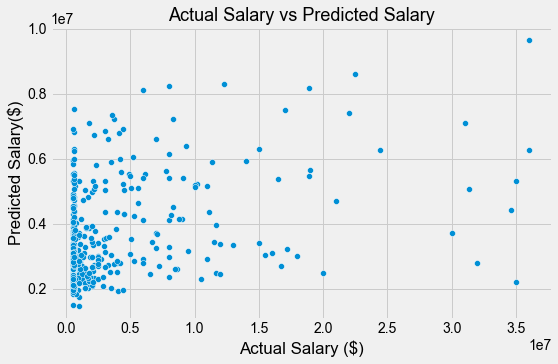

In [23]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (8, 5))
sns.scatterplot(x = df['salary'], y = vote.predict(X))

sns.set(font_scale=1.5)
plt.xlabel('Actual Salary ($)')
plt.ylabel('Predicted Salary($)')
plt.title('Actual Salary vs Predicted Salary');

Once againg there is a cluster on the left hand side of the graph. There is a lot more of a distinct cluster as compared to the batters. This is probably due to the fact that a lot more players have lower salaries. Again, I think the reason why the graph looks like this is because you have pitchers that perform well but still are on that "rookie" salary. Another reason that would really only apply to pitchers is that some pitchers only pitch for like one or two innings as compared to starting pitchers who pitch more so some of their stats can be elevated or deflated depending what type of pitcher you are. 

## Recap
---
This notebook used hitorical stats and salary to predict the salary of pitchers. Using the model created, the salary was predicted on the forecasted stats of pitchers for use in the app.